## 1) Importación de librerías necesarias

In [1]:
import pandas as pd
import os
import numpy as np
from PIL import Image
import pickle
import time
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [4]:
RANDOM_STATE=333

## 2) Funciones que se van a usar

In [5]:
"""
Given the main directory of the location of the images, the URL of each image is loaded to a dataframe with his clasification
"""
def loadData(path_main_directory):
    paths_list = list()
    label_list = list()

    for subdirectory in os.listdir(path_main_directory):
        #Build the path of every subdirectory of the main_directory
        path_subdirectory = os.path.join(path_main_directory, subdirectory)

        #Iterate over all the images of the subdirectory adding the path to the dictionary
        for image_name in os.listdir(path_subdirectory):
            image_path = os.path.join(path_subdirectory, image_name)
            paths_list.append(image_path)
            label_list.append(subdirectory)

        init_data_dict = {'path' : paths_list, 'label' : label_list}

    return pd.DataFrame(init_data_dict)

In [6]:
"""
Given the URL of the images as a list, the information of the size of the images is returned as a dataframe
"""
def getImageSizeInfo(images_path_L):
    #list of the size of each image
    images_size_L = list()
    #List of the width of each image
    images_width_L = list()
    #List of the height of each image
    images_height_L = list()
    #List of the ratio of the size of each image
    images_ratio_L = list()

    for path in images_path_L:
        image = Image.open(path)
        #Get the size of an image (given as a tuple) and append it to the list
        images_size_L.append(image.size)
        #Get the size of the image and append it to the list
        images_width_L.append(image.size[0])
        #Get the height of the image and append it to the list
        images_height_L.append(image.size[1])
        #Get the ratio (width/height) of the image and append it to the list
        images_ratio_L.append(round(image.size[0] / image.size[1], 2))

    #Dictionary with all the information
    image_info_D = {'path' : images_path_L, 'size' : images_size_L, 'width' : images_width_L, 'height' : images_height_L,'ratio' : images_ratio_L}
    #Data frame with all the information
    return pd.DataFrame(image_info_D)

In [7]:
def loadImages(tams_L, images_path_L, images_class_L):
    images_BW_D = dict()

    for i in range(0, len(tams_L)):
        #List of the representation of the images in black and white as a list
        imgs_BW_L = list()
        #List of the class of each image
        class_BW_L = list()

        for j in range(0, len(images_path_L)):
            #Open image and resize it
            img = Image.open(images_path_L[j]).resize(tams_L[i])
            #Image as a list
            arr = np.asarray(img, dtype = np.int_).flatten()
            
            imgs_BW_L.append(arr)
            class_BW_L.append(images_class_L[j])

        images_BW_D[i] = (imgs_BW_L, class_BW_L)
    
    return images_BW_D

In [8]:
"""
Given the name of the class, returns the associated numeric class
"""
def class_to_numeric(class_list):
    l = list()
    for i in range (0, len(class_list)):
        if(class_list[i] == 'angry'):
            l.append(0)
        elif(class_list[i] == 'happy'):
            l.append(1)
        elif(class_list[i] == 'sad'):
            l.append(2)
    return np.array(l)

In [9]:
def numeric_to_class(type):
    if(type == 0):
        return 'angry'
    elif(type == 1):
        return 'happy'
    else:
        return 'sad'

In [10]:
def decode(class_list):
    if(class_list[0] == 1):
        return 'angry'
    elif(class_list[1] == 1):
        return 'happy'
    else:
        return 'sad'

In [11]:
def createModel(num_layers, act, aph):
    mlp = MLPClassifier(hidden_layer_sizes=(num_layers, ), activation=act, solver='adam', alpha=aph, batch_size='auto',
                learning_rate_init=0.001, max_iter=1000, random_state=RANDOM_STATE)
    return mlp

## 2) Carga del conjunto de datos

Se van a cargar las URL de las imágenes en un dataframe junto a su clasificación.

El directorio principal está divido en 3 subdirectorios titulados: angry, happy y sad. Por lo que todas las URLs (imágenes) de un directorio tendrán esa clasificación.

In [12]:
#Main directory of the data
path_main_directory = './fer3'

#Load the data
init_data_df = loadData(path_main_directory)

display(init_data_df.head())
display(init_data_df.tail())

,path,label
0,./fer3\angry\PrivateTest_10131363.jpg,angry
1,./fer3\angry\PrivateTest_10304478.jpg,angry
2,./fer3\angry\PrivateTest_1054527.jpg,angry
3,./fer3\angry\PrivateTest_10590091.jpg,angry
4,./fer3\angry\PrivateTest_1109992.jpg,angry


,path,label
20014,./fer3\sad\Training_99922913.jpg,sad
20015,./fer3\sad\Training_99943858.jpg,sad
20016,./fer3\sad\Training_99950687.jpg,sad
20017,./fer3\sad\Training_99987906.jpg,sad
20018,./fer3\sad\Training_99996831.jpg,sad


Se calculan el número de ejemplos de cada clase

In [13]:
init_data_df['label'].value_counts()

label
happy    8989
sad      6077
angry    4953
Name: count, dtype: int64

Y se calcula la frecuencia de cada clase

In [14]:
init_data_df['label'].value_counts() / init_data_df['label'].count() * 100

label
happy    44.902343
sad      30.356162
angry    24.741496
Name: count, dtype: float64

Como se puede ver, la cantidad de datos de cada clase es muy similar, lo cual es una ventaja para entrenar el modelo.

## 3) Adaptación del formato de las imágenes

### Elección del tamaño:

  La elección del tamaño es muy importante, ya que tendrá efecto en el tiempo de entrenamiento del modelo y en la precisión del mismo. Aunque el tamaño de las imágenes del conjunto de datos elegido sea (48x48), se explorarán otros tamaños para evaluar los modelos con distintas características.

Se saca la información del tamaño de las imágenes y se guarda en un data frame

In [15]:
image_info_DF = getImageSizeInfo(init_data_df['path'].values)
display(image_info_DF.head())

,path,size,width,height,ratio
0,./fer3\angry\PrivateTest_10131363.jpg,"(48, 48)",48,48,1.0
1,./fer3\angry\PrivateTest_10304478.jpg,"(48, 48)",48,48,1.0
2,./fer3\angry\PrivateTest_1054527.jpg,"(48, 48)",48,48,1.0
3,./fer3\angry\PrivateTest_10590091.jpg,"(48, 48)",48,48,1.0
4,./fer3\angry\PrivateTest_1109992.jpg,"(48, 48)",48,48,1.0


Se van a probar con distintos tamaños (todos ellos dependiendientes de la anchura y altura original)

In [16]:
tams_L = list()
tams_L.append((96, 96)) #original size *2
tams_L.append((48, 48)) #original size
tams_L.append((24, 24)) #original size /2
print(tams_L)

[(96, 96), (48, 48), (24, 24)]


# Pruebas nuevas tamaños

Se van a generar varios conjuntos de datos: cada uno de ellos contendrá las imágenes en blanco y negro con distintos tamaños.

In [17]:
load_images  = loadImages(tams_L, init_data_df['path'].values, init_data_df['label'].values)

Se ve la forma de cada uno de los conjuntos de datos

In [18]:
for i in range(0, len(tams_L)):
    print(np.array(load_images[i][0]).shape)
    print(np.array(load_images[i][1]).shape)

(20019, 9216)
(20019,)
(20019, 2304)
(20019,)
(20019, 576)
(20019,)


Se visualiza una imagen de prueba para ver los cambios realizados tras redimensionar

Clase:  angry


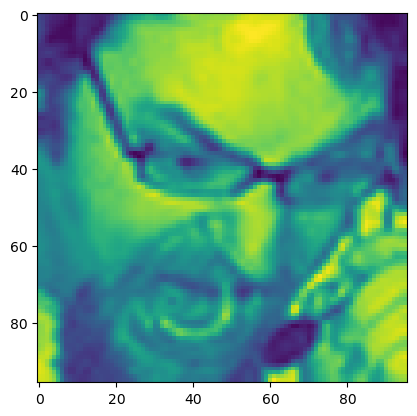

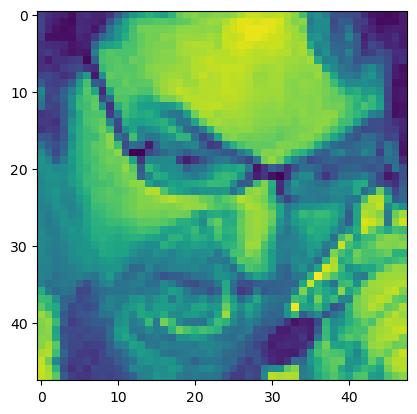

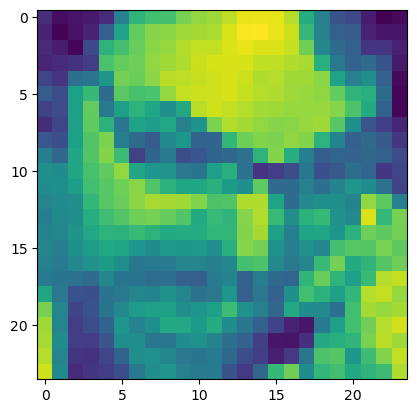

In [19]:
print("Clase: ", load_images[0][1][1])
for i in range (0, len(tams_L)):
    l = list(tams_L[i])
    image = Image.fromarray(load_images[i][0][0].reshape(tuple(l)).astype(np.uint8))
    plt.imshow(image)
    plt.show()

In [20]:
#Dictionary with the train test splits for all the representations
load_train_test = dict()
for i in range(0, len(tams_L)):
    X_train, X_test, y_train, y_test = train_test_split(load_images[i][0], load_images[i][1], test_size=0.2,shuffle=True)
    load_train_test[i] = (np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test))
    print('X_train shape:', np.array(X_train).shape, 'y_train shape:', np.array(y_train).shape, 'X_test shape:', np.array(X_test).shape, 'y_test shape:', np.array(y_test).shape)

X_train shape: (16015, 9216) y_train shape: (16015,) X_test shape: (4004, 9216) y_test shape: (4004,)
X_train shape: (16015, 2304) y_train shape: (16015,) X_test shape: (4004, 2304) y_test shape: (4004,)
X_train shape: (16015, 576) y_train shape: (16015,) X_test shape: (4004, 576) y_test shape: (4004,)


In [22]:
#create a model for each image size, activation function, kernel size and pooling size
alpha_params_L = np.arange(0.01, 1.6, step=0.5)
activations_functions_L = ['relu', 'logistic']

modelsTams = dict()
for i in range(0, len(tams_L)):
    models = dict()
    j=0
    for aph in alpha_params_L:
        for num_layers in range(150, 250, 50):
            for act in activations_functions_L:
                model = createModel(num_layers, act, aph);
                models[j] = model
                j += 1
    modelsTams[i] = models

In [23]:
#print the summary of each model
for i in range(0, len(tams_L)):
    for j in range (0, len(modelsTams[i])):
        print("Model ", i, j);
        print(modelsTams[i][j].hidden_layer_sizes)
        print(modelsTams[i][j].activation)
        print(modelsTams[i][j].alpha)

Model  0 0
(150,)
relu
0.01
Model  0 1
(150,)
logistic
0.01
Model  0 2
(200,)
relu
0.01
Model  0 3
(200,)
logistic
0.01
Model  0 4
(150,)
relu
0.51
Model  0 5
(150,)
logistic
0.51
Model  0 6
(200,)
relu
0.51
Model  0 7
(200,)
logistic
0.51
Model  0 8
(150,)
relu
1.01
Model  0 9
(150,)
logistic
1.01
Model  0 10
(200,)
relu
1.01
Model  0 11
(200,)
logistic
1.01
Model  0 12
(150,)
relu
1.51
Model  0 13
(150,)
logistic
1.51
Model  0 14
(200,)
relu
1.51
Model  0 15
(200,)
logistic
1.51
Model  1 0
(150,)
relu
0.01
Model  1 1
(150,)
logistic
0.01
Model  1 2
(200,)
relu
0.01
Model  1 3
(200,)
logistic
0.01
Model  1 4
(150,)
relu
0.51
Model  1 5
(150,)
logistic
0.51
Model  1 6
(200,)
relu
0.51
Model  1 7
(200,)
logistic
0.51
Model  1 8
(150,)
relu
1.01
Model  1 9
(150,)
logistic
1.01
Model  1 10
(200,)
relu
1.01
Model  1 11
(200,)
logistic
1.01
Model  1 12
(150,)
relu
1.51
Model  1 13
(150,)
logistic
1.51
Model  1 14
(200,)
relu
1.51
Model  1 15
(200,)
logistic
1.51
Model  2 0
(150,)
relu
0.01


In [24]:
#data conditioning for each model
train_test_conditioned = dict()

for i in range(0, len(tams_L)):
    X_train = load_train_test[i][0]
    X_train = X_train.astype('float32') / 255
    
    X_test = load_train_test[i][1]
    X_test = X_test.astype('float32') / 255
    
    y_train = load_train_test[i][2]
    y_train = class_to_numeric(y_train) # Converts the string class to numeric class
    y_train = to_categorical(y_train) # Converts the classes into one-hot-vector
    
    y_test = load_train_test[i][3]
    y_test = class_to_numeric(y_test) # Converts the string class to numeric class
    y_test = to_categorical(y_test) # Converts the classes into one-hot-vector

    print('X_train shape:', X_train.shape, 'X_test shape:', X_test.shape, 'y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)
    
    train_test_conditioned[i] = (X_train, X_test, y_train, y_test)

X_train shape: (16015, 9216) X_test shape: (4004, 9216) y_train shape: (16015, 3) y_test shape: (4004, 3)
X_train shape: (16015, 2304) X_test shape: (4004, 2304) y_train shape: (16015, 3) y_test shape: (4004, 3)
X_train shape: (16015, 576) X_test shape: (4004, 576) y_train shape: (16015, 3) y_test shape: (4004, 3)


## Train the models

In [25]:
#train the models
times = list()
accuracies = list()
for i in range(0, len(tams_L)):
    time_tam = list()
    accuracy_tam = list()
    for j in range (0, len(modelsTams[i])):
        print("Model ", i, j);
        start = time.time()
        modelsTams[i][j].fit(train_test_conditioned[i][0], train_test_conditioned[i][2])
        stop = time.time()
        time_tam.append(stop-start)
        train_accuracy = modelsTams[i][j].score(train_test_conditioned[i][0], train_test_conditioned[i][2])
        print("Training score:", train_accuracy)
        accuracy_tam.append(train_accuracy)
    times.append(time_tam)
    accuracies.append(accuracy_tam)

Model  0 0
Training score: 0.3983765220106151
Model  0 1
Training score: 0.4565095223228224
Model  0 2
Training score: 0.573087730252888
Model  0 3
Training score: 0.4430221667187012
Model  0 4
Training score: 0.4305338744926631
Model  0 5
Training score: 0.36228535747736496
Model  0 6
Training score: 0.3746487667811427
Model  0 7
Training score: 0.3491102091788948
Model  0 8
Training score: 0.2806119263190759
Model  0 9
Training score: 0.30546362784889164
Model  0 10
Training score: 0.31782703715266936
Model  0 11
Training score: 0.3956915391820169
Model  0 12
Training score: 0.25719637839525444
Model  0 13
Training score: 0.3955042147986263
Model  0 14
Training score: 0.4169840774274118
Model  0 15
Training score: 0.3025913206369029
Model  1 0
Training score: 0.6324071183265688
Model  1 1
Training score: 0.9748985326256634
Model  1 2
Training score: 0.6349672182329067
Model  1 3
Training score: 0.9884483296909148
Model  1 4
Training score: 0.4417108960349672
Model  1 5
Training score

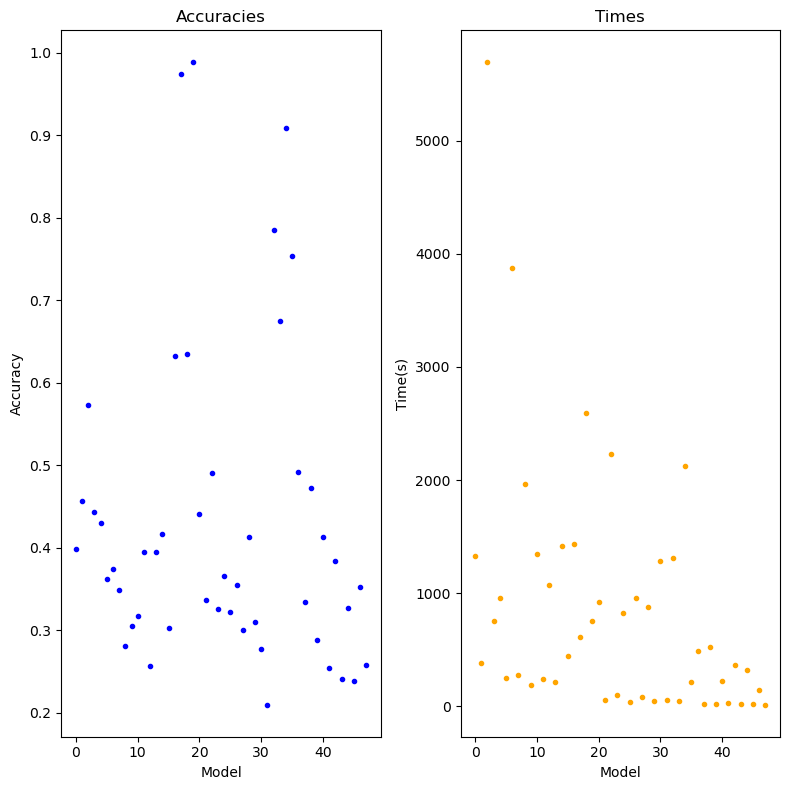

In [26]:
## print the accuracies and times obtained
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,8))

ax1.scatter(list(range(0, len(tams_L)*len(modelsTams[0]))), [x for sublist in accuracies for x in sublist], color='blue', marker='.')
ax1.set_title('Accuracies')
ax1.set_xlabel('Model')
ax1.set_ylabel('Accuracy')

ax2.scatter(list(range(0, len(tams_L)*len(modelsTams[0]))), [x for sublist in times for x in sublist], color='orange', marker='.')
ax2.set_title('Times')
ax2.set_xlabel('Model')
ax2.set_ylabel('Time(s)')

plt.tight_layout()
plt.show()

## Evaluate the models

In [27]:
acc = 0
for i in range(0, len(tams_L)):
    for j in range (0, len(modelsTams[i])):
        print("Model ", i, j);
        y_predict_test = modelsTams[i][j].predict(train_test_conditioned[i][1])
        score = accuracy_score(train_test_conditioned[i][3], y_predict_test)

        print("Test accuracy: ", score)
        if(score > acc):
            acc = score
            best_i = i
            best_j = j
print("Best model ", best_i, best_j)

Model  0 0
Test accuracy:  0.3356643356643357
Model  0 1
Test accuracy:  0.42032967032967034
Model  0 2
Test accuracy:  0.42332667332667334
Model  0 3
Test accuracy:  0.3991008991008991
Model  0 4
Test accuracy:  0.40884115884115885
Model  0 5
Test accuracy:  0.3439060939060939
Model  0 6
Test accuracy:  0.34265734265734266
Model  0 7
Test accuracy:  0.33816183816183815
Model  0 8
Test accuracy:  0.2754745254745255
Model  0 9
Test accuracy:  0.2917082917082917
Model  0 10
Test accuracy:  0.3041958041958042
Model  0 11
Test accuracy:  0.3918581418581419
Model  0 12
Test accuracy:  0.24475524475524477
Model  0 13
Test accuracy:  0.3903596403596404
Model  0 14
Test accuracy:  0.3986013986013986
Model  0 15
Test accuracy:  0.3026973026973027
Model  1 0
Test accuracy:  0.4542957042957043
Model  1 1
Test accuracy:  0.5062437562437563
Model  1 2
Test accuracy:  0.4657842157842158
Model  1 3
Test accuracy:  0.5147352647352648
Model  1 4
Test accuracy:  0.3853646353646354
Model  1 5
Test accura

In [28]:
# Visualize the summary of the best model
activation_function = modelsTams[best_i][best_j].activation
hidden_layer_sizes = modelsTams[best_i][best_j].hidden_layer_sizes
alpha = modelsTams[best_i][best_j].alpha

print("Input size:", tams_L[best_i])
print("Activation function: ", activation_function)
print("Hidden layer sizes: ", hidden_layer_sizes)
print("Alpha: ", alpha)

Input size: (48, 48)
Activation function:  logistic
Hidden layer sizes:  (200,)
Alpha:  0.01


In [29]:
from sklearn.metrics import classification_report

In [30]:
#Predict using the trained model against training dataset
y_predict_train = modelsTams[best_i][best_j].predict(train_test_conditioned[best_i][0])

#Predict using the trained model against test dataset
y_predict_test = modelsTams[best_i][best_j].predict(train_test_conditioned[best_i][1])

#Accuracy of the model for the train dataset
acc_train = accuracy_score(train_test_conditioned[best_i][2], y_predict_train)
#Clasification report for the train dataset
classif_rep_train = classification_report(train_test_conditioned[best_i][2], y_predict_train)

#Accuracy of the model for the test dataset
acc_test = accuracy_score(train_test_conditioned[best_i][3], y_predict_test)
#Clasification report for the train dataset
classif_rep_test = classification_report(train_test_conditioned[best_i][3], y_predict_test)

C:\Users\javie\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\javie\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
#análisis para el dataset de entrenamiento
print('Precisión : ', acc_train)
print('Report : ')
print(classif_rep_train)

Precisión :  0.9884483296909148
Report : 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4021
           1       0.99      1.00      1.00      7100
           2       1.00      0.99      0.99      4894

   micro avg       1.00      0.99      0.99     16015
   macro avg       1.00      0.99      0.99     16015
weighted avg       1.00      0.99      0.99     16015
 samples avg       0.99      0.99      0.99     16015



In [32]:
#análisis para el dataset de entrenamiento
print('Precisión : ', acc_test)
print('Report : ')
print(classif_rep_test)

Precisión :  0.5147352647352648
Report : 
              precision    recall  f1-score   support

           0       0.52      0.33      0.40       932
           1       0.69      0.76      0.72      1889
           2       0.53      0.48      0.50      1183

   micro avg       0.61      0.57      0.59      4004
   macro avg       0.58      0.52      0.54      4004
weighted avg       0.60      0.57      0.58      4004
 samples avg       0.54      0.57      0.55      4004



Como se puede ver, el modelo no es nada bueno, pero era lo esperable, ya que las MLPs no son el mejor modelo para análisis de imágenes. 

Además, al disponer de tan pocos datos, el entrenamiento de la red es bastante pobre

## Save the best model

In [33]:
model_pkl_file = "./MLP_classifier_fer3.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(modelsTams[best_i][best_j], file)

## Visualize the confusion matrix of each model

In [34]:
#process the real classes for the confusion matrix
y_real = list()
for i in range(0, len(tams_L)):
    instances = train_test_conditioned[i][3]
    y_instance = list()
    for k in range (0, len(instances)):
        y_instance.append(decode(instances[k]))
    y_real.append(y_instance)

model:  0 0


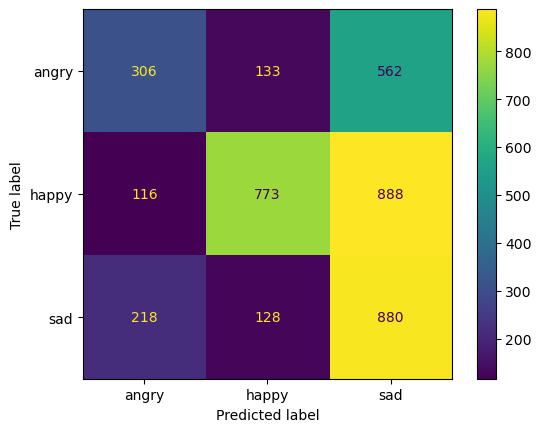

model:  0 1


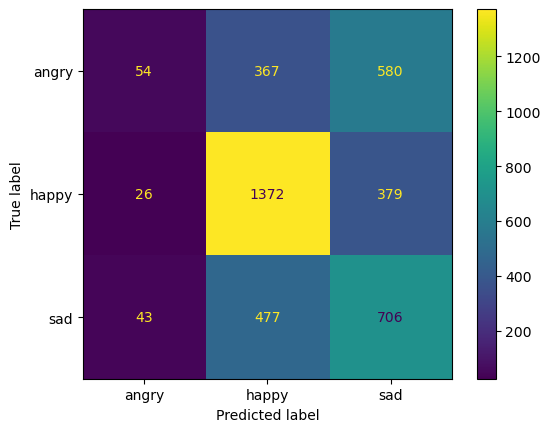

model:  0 2


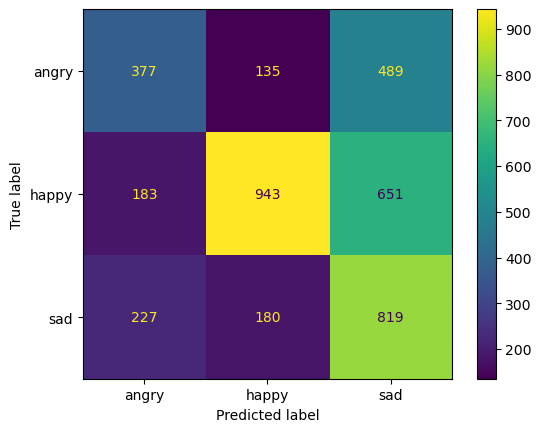

model:  0 3


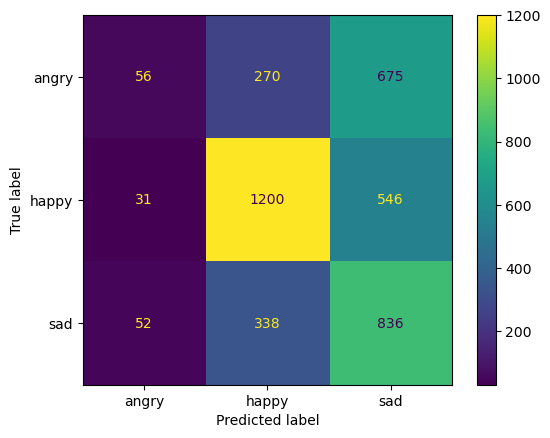

model:  0 4


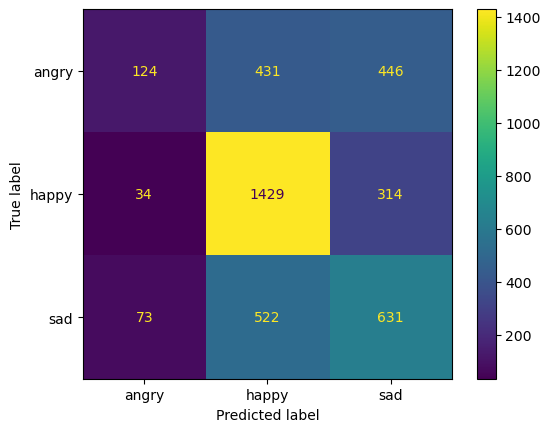

model:  0 5


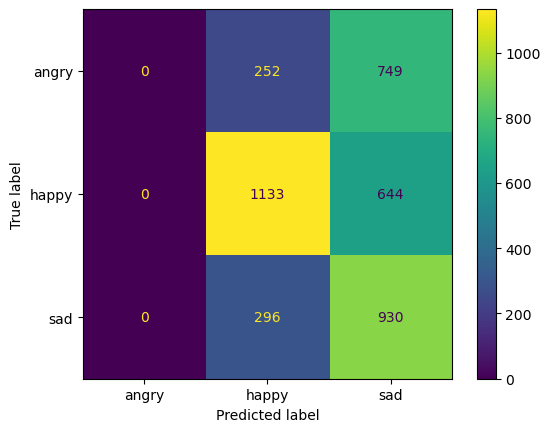

model:  0 6


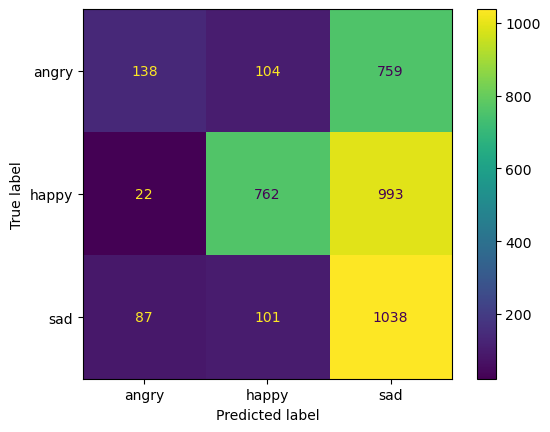

model:  0 7


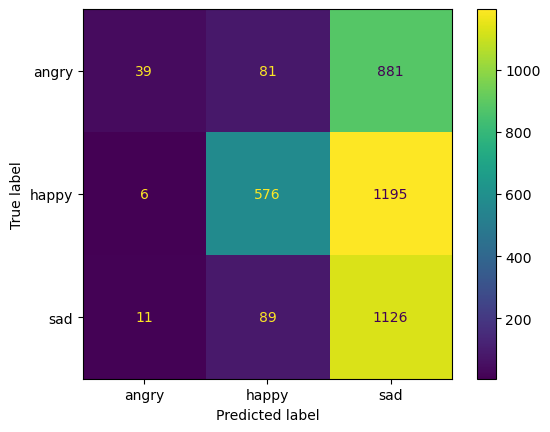

model:  0 8


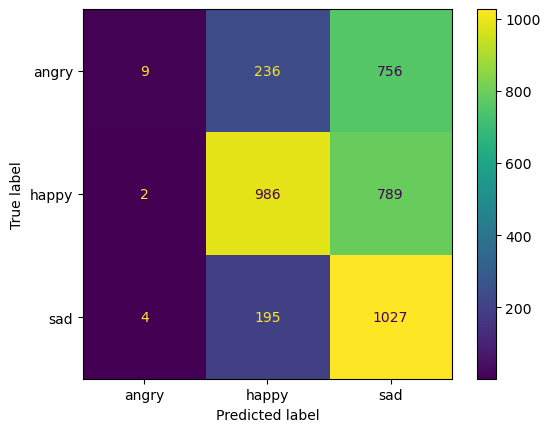

model:  0 9


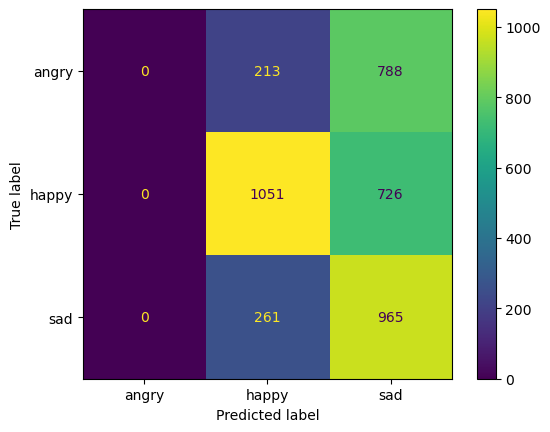

model:  0 10


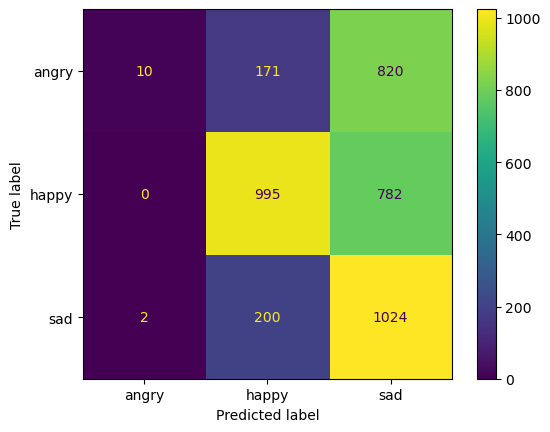

model:  0 11


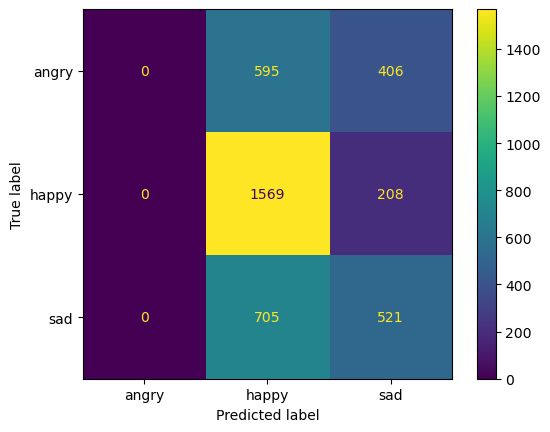

model:  0 12


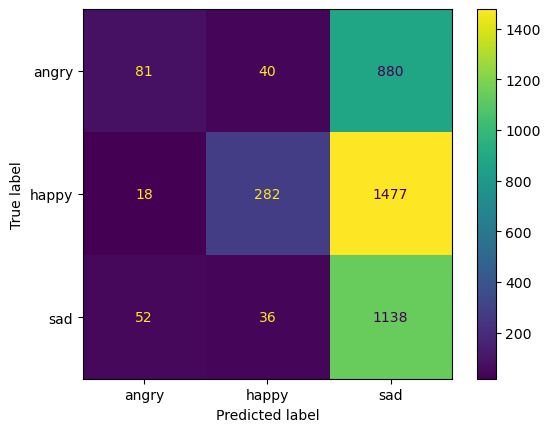

model:  0 13


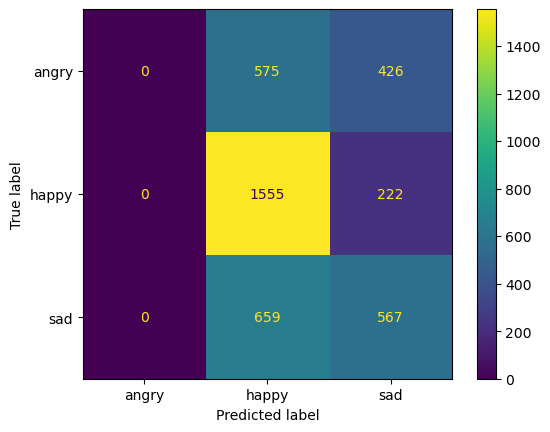

model:  0 14


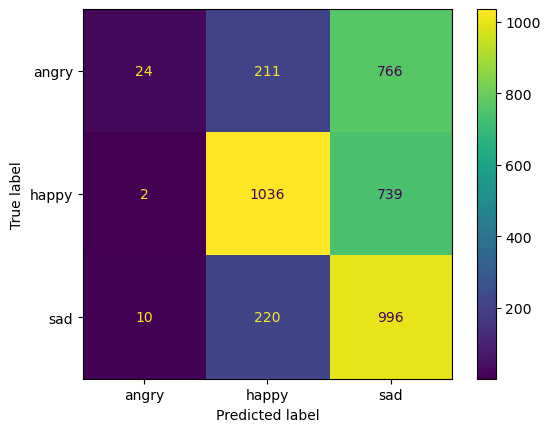

model:  0 15


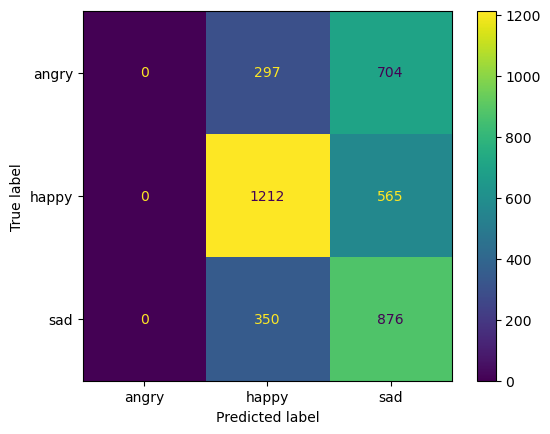

model:  1 0


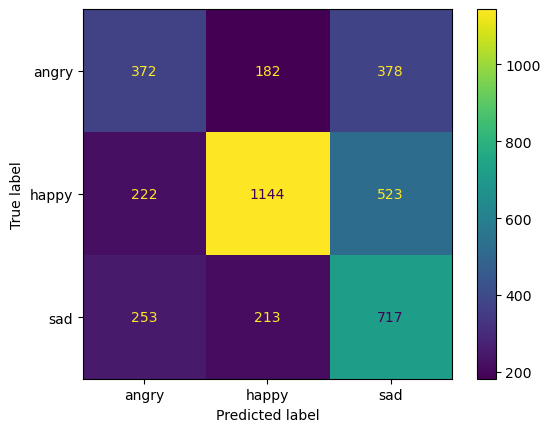

model:  1 1


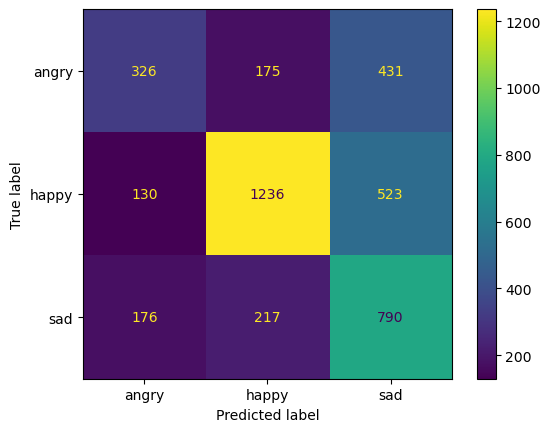

model:  1 2


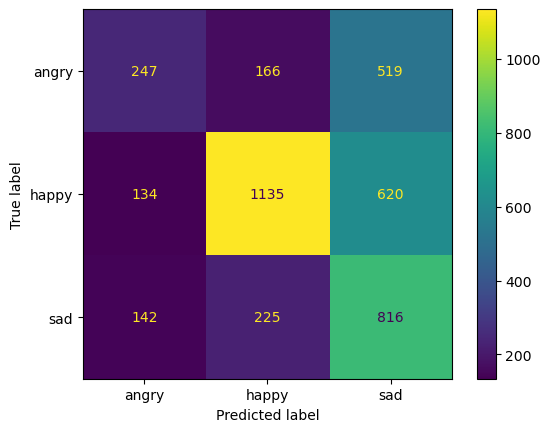

model:  1 3


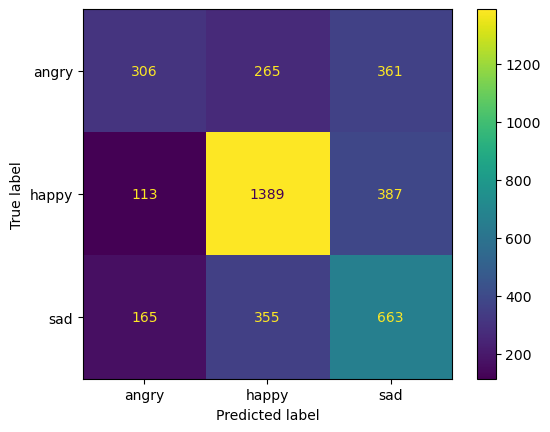

model:  1 4


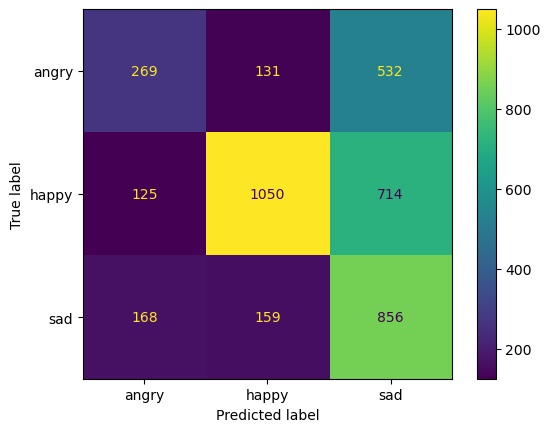

model:  1 5


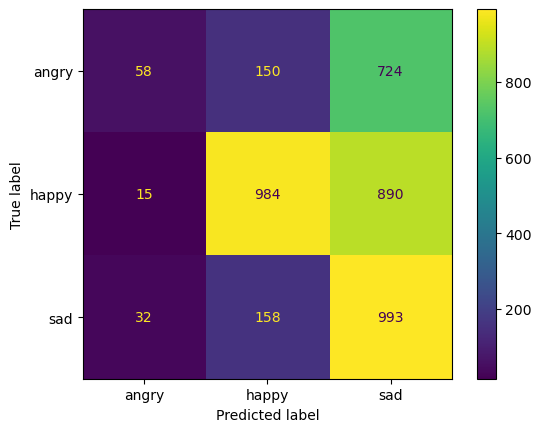

model:  1 6


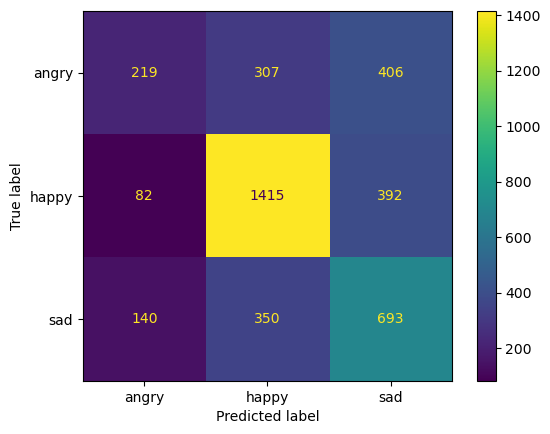

model:  1 7


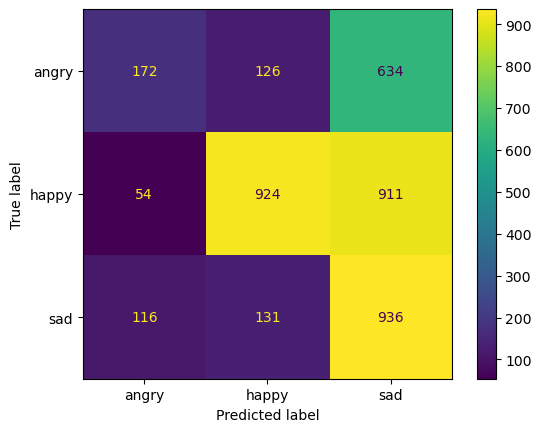

model:  1 8


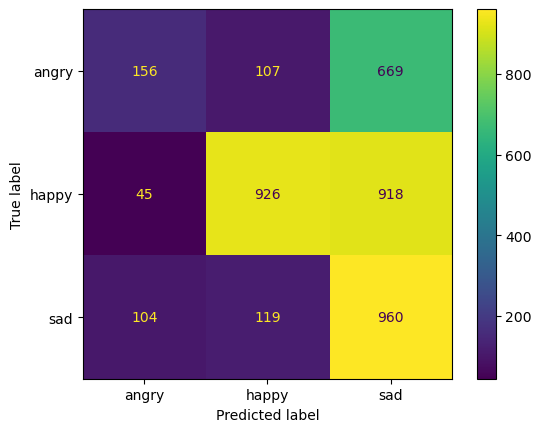

model:  1 9


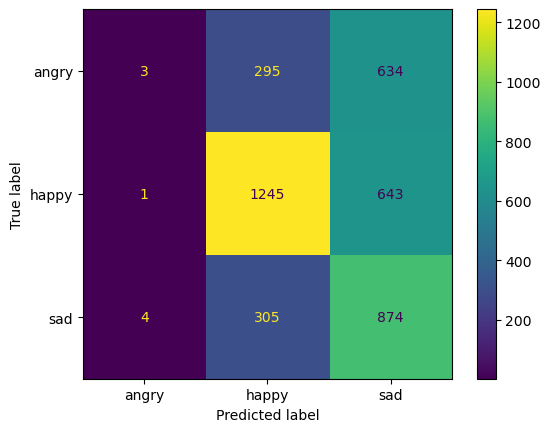

model:  1 10


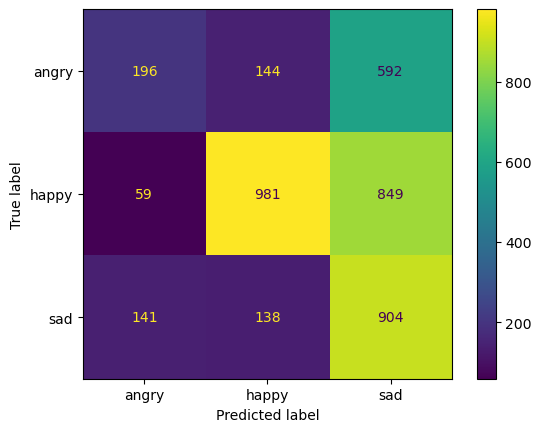

model:  1 11


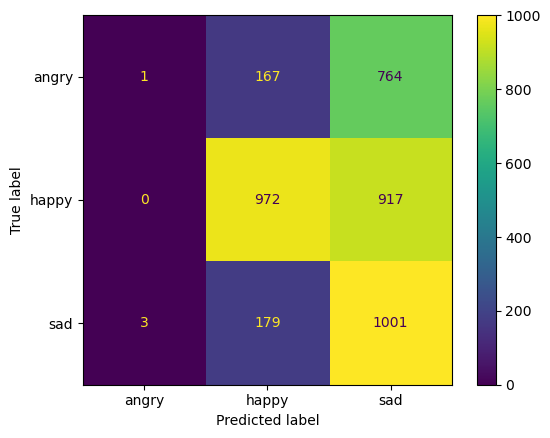

model:  1 12


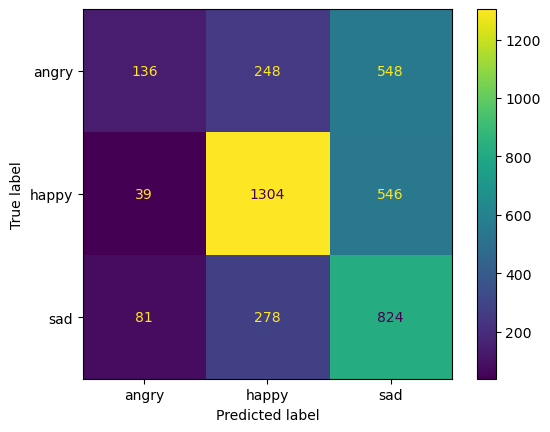

model:  1 13


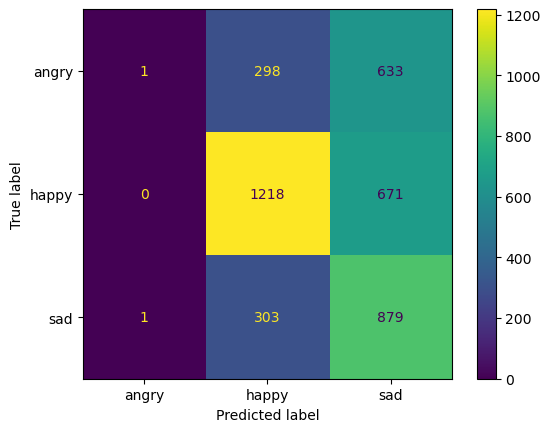

model:  1 14


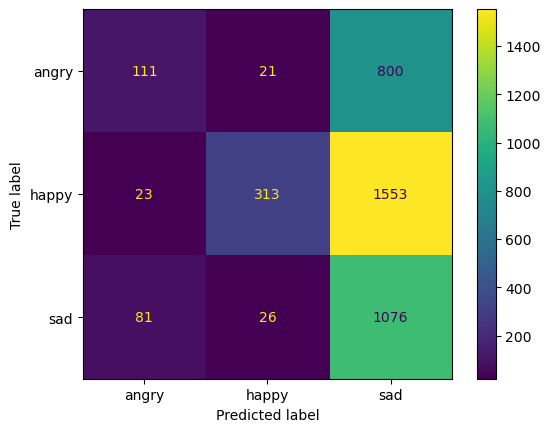

model:  1 15


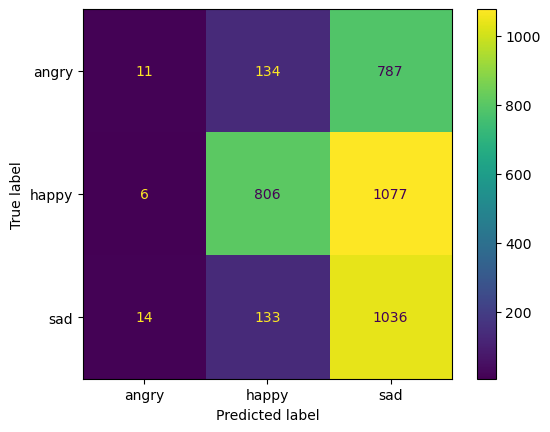

model:  2 0


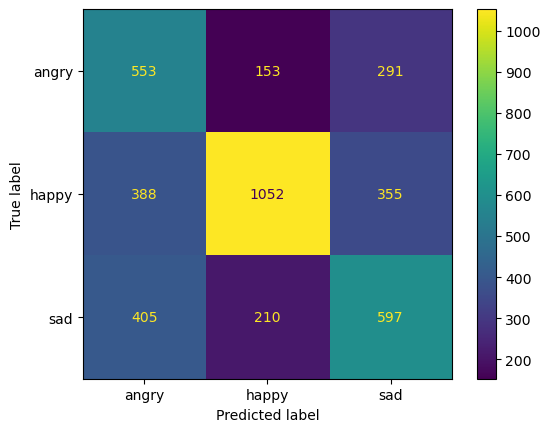

model:  2 1


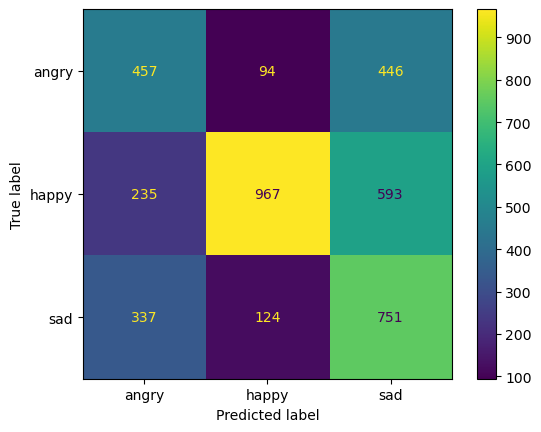

model:  2 2


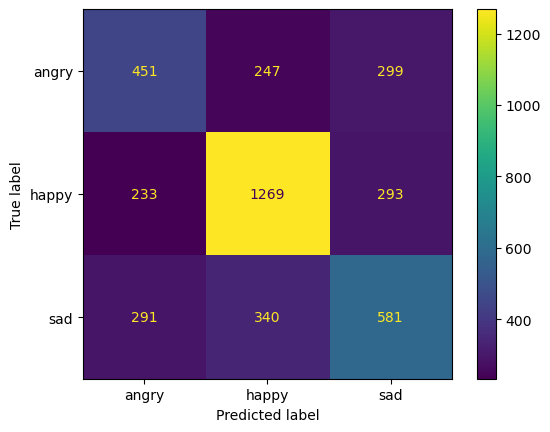

model:  2 3


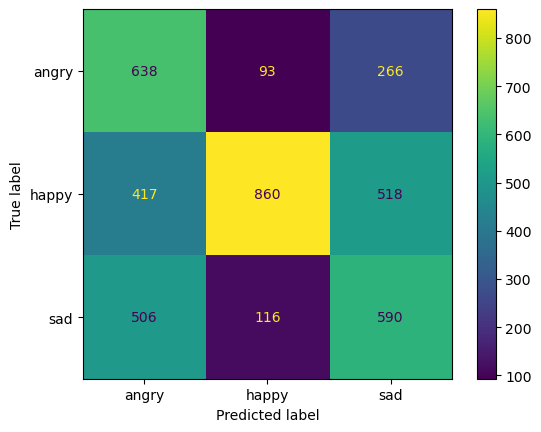

model:  2 4


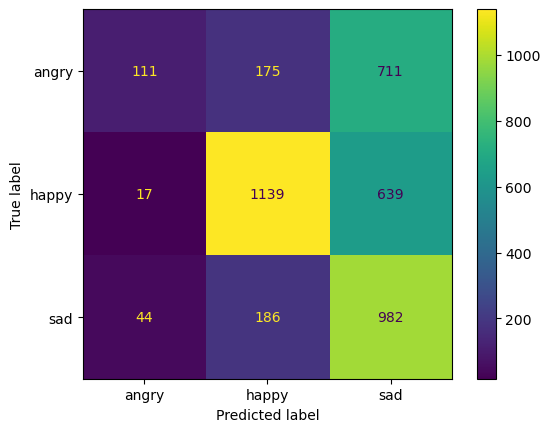

model:  2 5


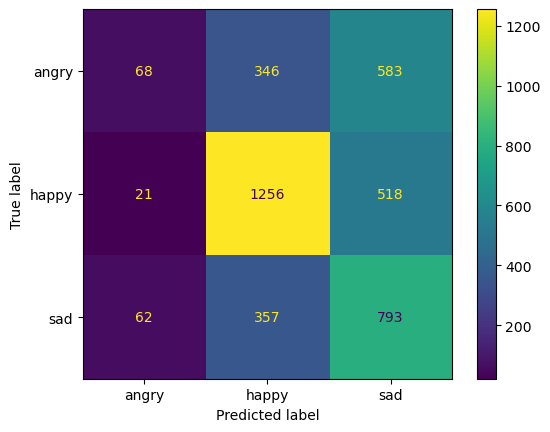

model:  2 6


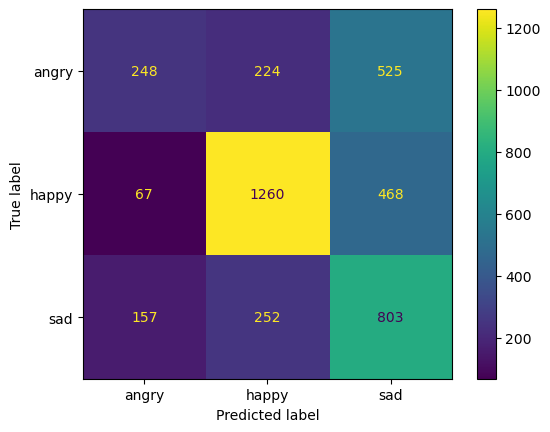

model:  2 7


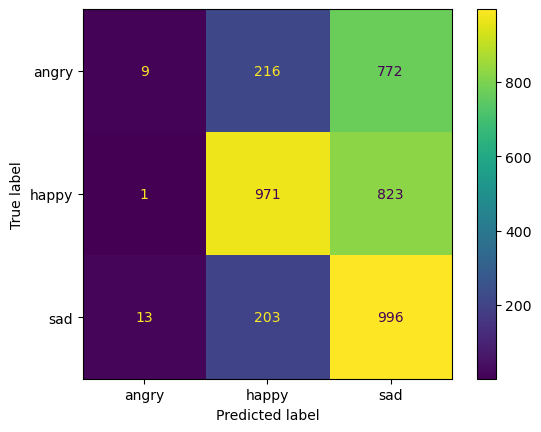

model:  2 8


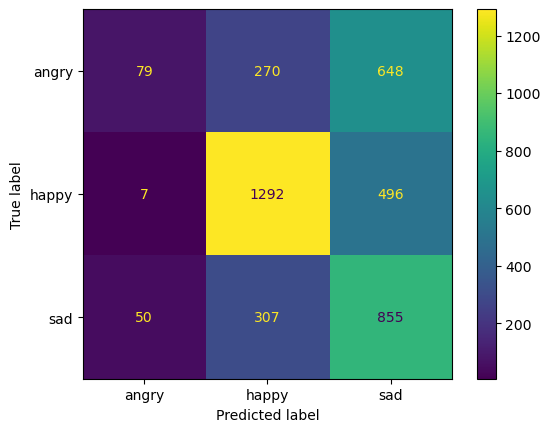

model:  2 9


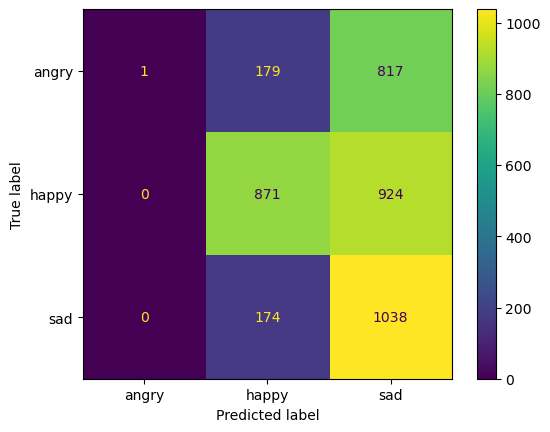

model:  2 10


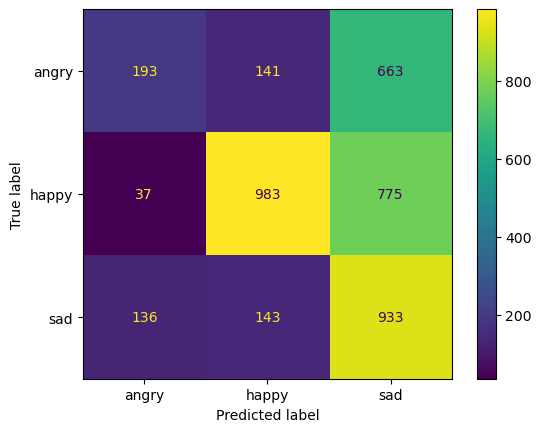

model:  2 11


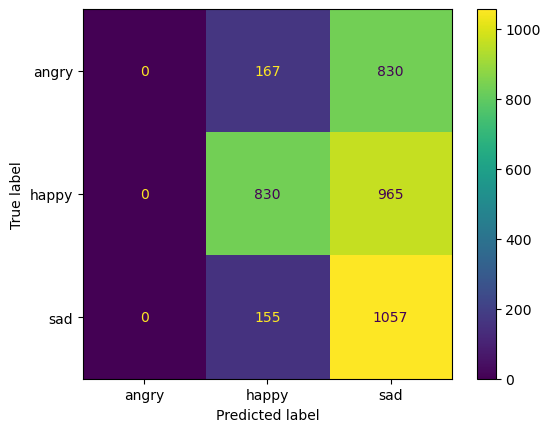

model:  2 12


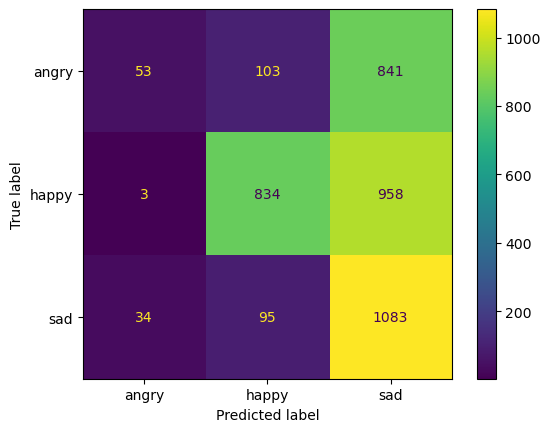

model:  2 13


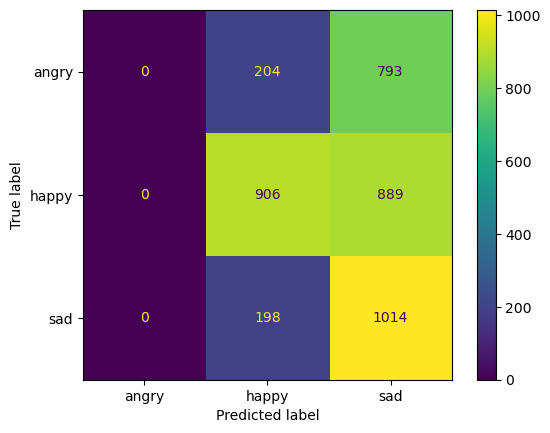

model:  2 14


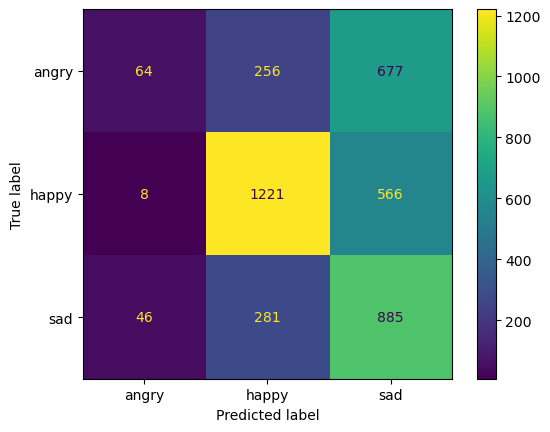

model:  2 15


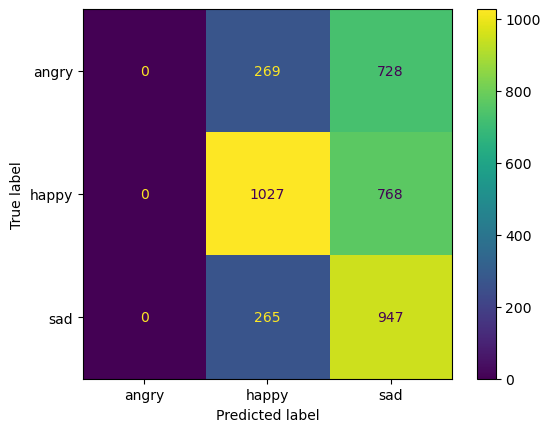

In [35]:
for i in range(0, len(tams_L)):
    instances = train_test_conditioned[i][1] #test data
    for j in range (0, len(modelsTams[i])):
        predictions_j = list()
        for k in range (0, len(instances)):
            predictions_j.append(decode(modelsTams[i][j].predict(instances[k].reshape(1,-1))[0]))
        print("model: ", i, j)
        #confusion matrix
        cm = confusion_matrix(y_real[i], predictions_j, labels=['angry', 'happy','sad'])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['angry', 'happy','sad'])
        disp.plot()
        plt.show()